In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()

###############
# CONST
###############
import os
from src.utils.const import *

# add paths to files
matlabpath = os.path.join(BASEPATH, 'matlab')
s = eng.genpath(matlabpath)
eng.addpath(s, nargout=0)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

###############
# SPECIFICS
###############

locations = ['outdoor', 'indoor']
prefixes = {
    'indoor': ['in'],
    'outdoor': ['']
}
positions = {
    'indoor': ['bas', 'low', 'pad'],
    'outdoor': ['']
}

In [24]:
###############
# INVERSIONS
#   with
# FRESNEL
###############


for location in locations:
    
    names = os.listdir( os.path.join(datarawpath, location) )
    
    # create folder if not exists
    if not os.path.exists(os.path.join(inversionpath, location)):
        os.makedirs(os.path.join(inversionpath, location))  

    # instead of doing this:
    #   plutos = [name for name in names if name.endswith('.log')]
    #   sambas = [name for name in names if name.endswith('.csv')]
    # we just take the names without extention:
    names_list = [name.split('.')[0] for name in names]
    union = set(names_list)
    intersection = set([ el for el in union if names_list.count(el) > 1])
    
    diff = union - intersection

    for name in intersection:
        pluto = f'{name}.log'
        samba = f'{name}.csv'

        for prefix in prefixes[location]:
            try:
                eng.workspace['pluto']= os.path.join(datarawpath, location, pluto)
                eng.workspace['trace']= os.path.join(datarawpath, location, samba)

                eng.eval(f"[F,FI,FQ,P_X,P_Y,P_MOD,P_PHASE] = merge_acquisition(trace, pluto);",nargout=0)
                # F = eng.workspace['F']
                # P_X = eng.workspace['P_X']
                # P_Y = eng.workspace['P_Y']
                # P_I = eng.workspace['P_MOD']
                # P_Q = eng.workspace['P_PHASE']

                eng.eval(f"[MO, PH, H, Hfill] = fast_generate_hologram(F, FI, FQ, 5, P_X, P_Y, P_MOD, P_PHASE, 2, 3);",nargout=0)

                # MO = eng.workspace['MO']
                # PH = eng.workspace['PH']
                # H = eng.workspace['H']
                # eng.eval("Hfill_app = cell2mat(Hfill);", nargout=0)
                # Hfill_app = eng.workspace['Hfill_app']
                # Hfill_app = np.asarray(Hfill_app, dtype = 'complex_')

                #!################
                #! VARIABLES
                #!################

                eng.workspace['epsilon'] = 4 if location == 'outdoor' else 1
                eng.eval("epsilon = double(epsilon);", nargout=0)
                eng.workspace['in_line'] = 0
                eng.eval("in_line = double(in_line);", nargout=0)
                
                #!DAFAULT
                # eng.workspace['min'] = 0
                # eng.eval("min = double(min)/1e2;", nargout=0)
                # eng.workspace['max'] = 40
                # eng.eval("max = double(max)/1e2;", nargout=0)
                # eng.workspace['step'] = 100
                # eng.eval("step = double(step);", nargout=0)
                # eng.workspace['pad_size'] = 0
                # eng.eval("pad_size = double(pad_size);", nargout=0)
                # eng.workspace['scale_factor'] = 1
                # eng.eval("scale_factor = double(scale_factor);", nargout=0)
                # eng.workspace['resizeFlag'] = 0
                # eng.eval("resizeFlag = double(resizeFlag);", nargout=0)
                
                # inversion algorithm can be one of:
                # - Fresnel
                # - Conv
                # - AngSpec
                # - newAngSpec
                
                eng.eval("[Inv] = fast_inversion(Hfill, F, epsilon, 'newAngSpec', in_line);", nargout=0)
                eng.eval("Inv_app = cell2mat(Inv);", nargout=0)
                Inv_app = eng.workspace['Inv_app']
                Inv = np.asarray(Inv_app, dtype = 'complex_')
                np.save(file=os.path.join(inversionpath, location, f'{name}_0.npy'), arr=Inv)

                eng.eval("[Inv180] = fast_inversion(Hfill.*exp(1i*pi), F, epsilon, 'newAngSpec', in_line);", nargout=0)
                eng.eval("Inv180_app = cell2mat(Inv180);", nargout=0)
                Inv180_app = eng.workspace['Inv180_app']
                Inv180 = np.asarray(Inv180_app, dtype = 'complex_')
                np.save(file=os.path.join(inversionpath, location, f'{name}_180.npy'), arr=Inv180)

            except Exception as e:
                print(name, e)
    #         break
    #     break
    # break

36_205_6 Output argument "MO" (and possibly others) not assigned a value in the execution with "fast_generate_hologram" function.



Output argument "MO" (and possibly others) not assigned a value in the
execution with "fast_generate_hologram" function.



In [23]:
name

'36_205_6'

In [6]:
Hfill_app = eng.workspace['Hfill']
Hfill_app = np.asarray(Hfill_app, dtype = 'complex_')


In [7]:
print(np.real(Hfill_app))

[[2113.74262423 2107.85739658 2100.20840719 ... 2099.68443232
  2100.53429016 2102.37301209]
 [2114.67118137 2107.43872546 2098.57129363 ... 2099.1534732
  2101.58682875 2103.19718898]
 [2114.38971971 2105.02411744 2097.73746798 ... 2099.45179211
  2102.3739218  2103.72004573]
 ...
 [2097.42584599 2087.3578377  2078.38459028 ... 2094.95205259
  2097.29335036 2098.82937243]
 [2093.3575099  2084.48058797 2075.80142631 ... 2092.52028049
  2095.60322805 2095.82243084]
 [2089.26423293 2082.15140999 2073.61447994 ... 2090.12626926
  2092.35569563 2093.31190558]]


Text(0.5, 1.0, 'distance')

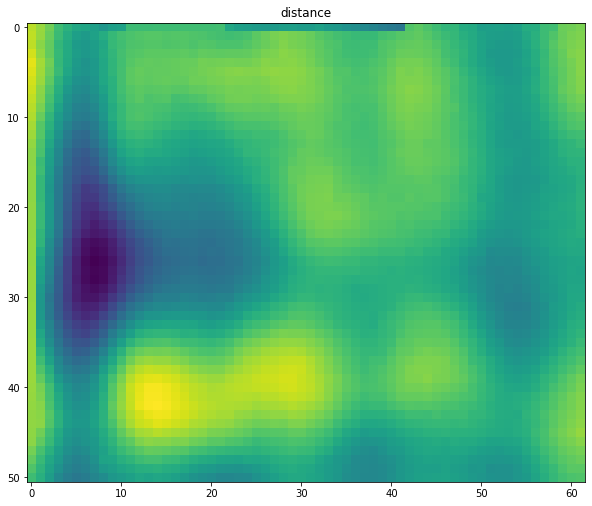

In [8]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.real(Hfill_app))
plt.title(f'distance')

In [17]:
F = eng.workspace['F']

In [18]:
print(F)

1900000000.0


In [16]:
# Import data
import time
import numpy as np
from skimage import io

# normalization
Inv_real = np.real(Inv180)
Inv_app = np.nan_to_num(Inv_real)
import copy
Inv0_real = Inv_app # [:,:,::-1]
Inv0_real_norm_complete =  copy.copy(Inv0_real)

for z in range(Inv0_real.shape[-1]):
    
    Inv0_real_norm = Inv0_real[:,:,z]
    Inv0_real_norm = (Inv0_real_norm-np.min(Inv0_real_norm))/(np.max(Inv0_real_norm)-np.min(Inv0_real_norm))
    Inv0_real_norm_complete[:,:,z] = Inv0_real_norm

In [17]:
Inv0_real.shape

(62, 62, 41)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

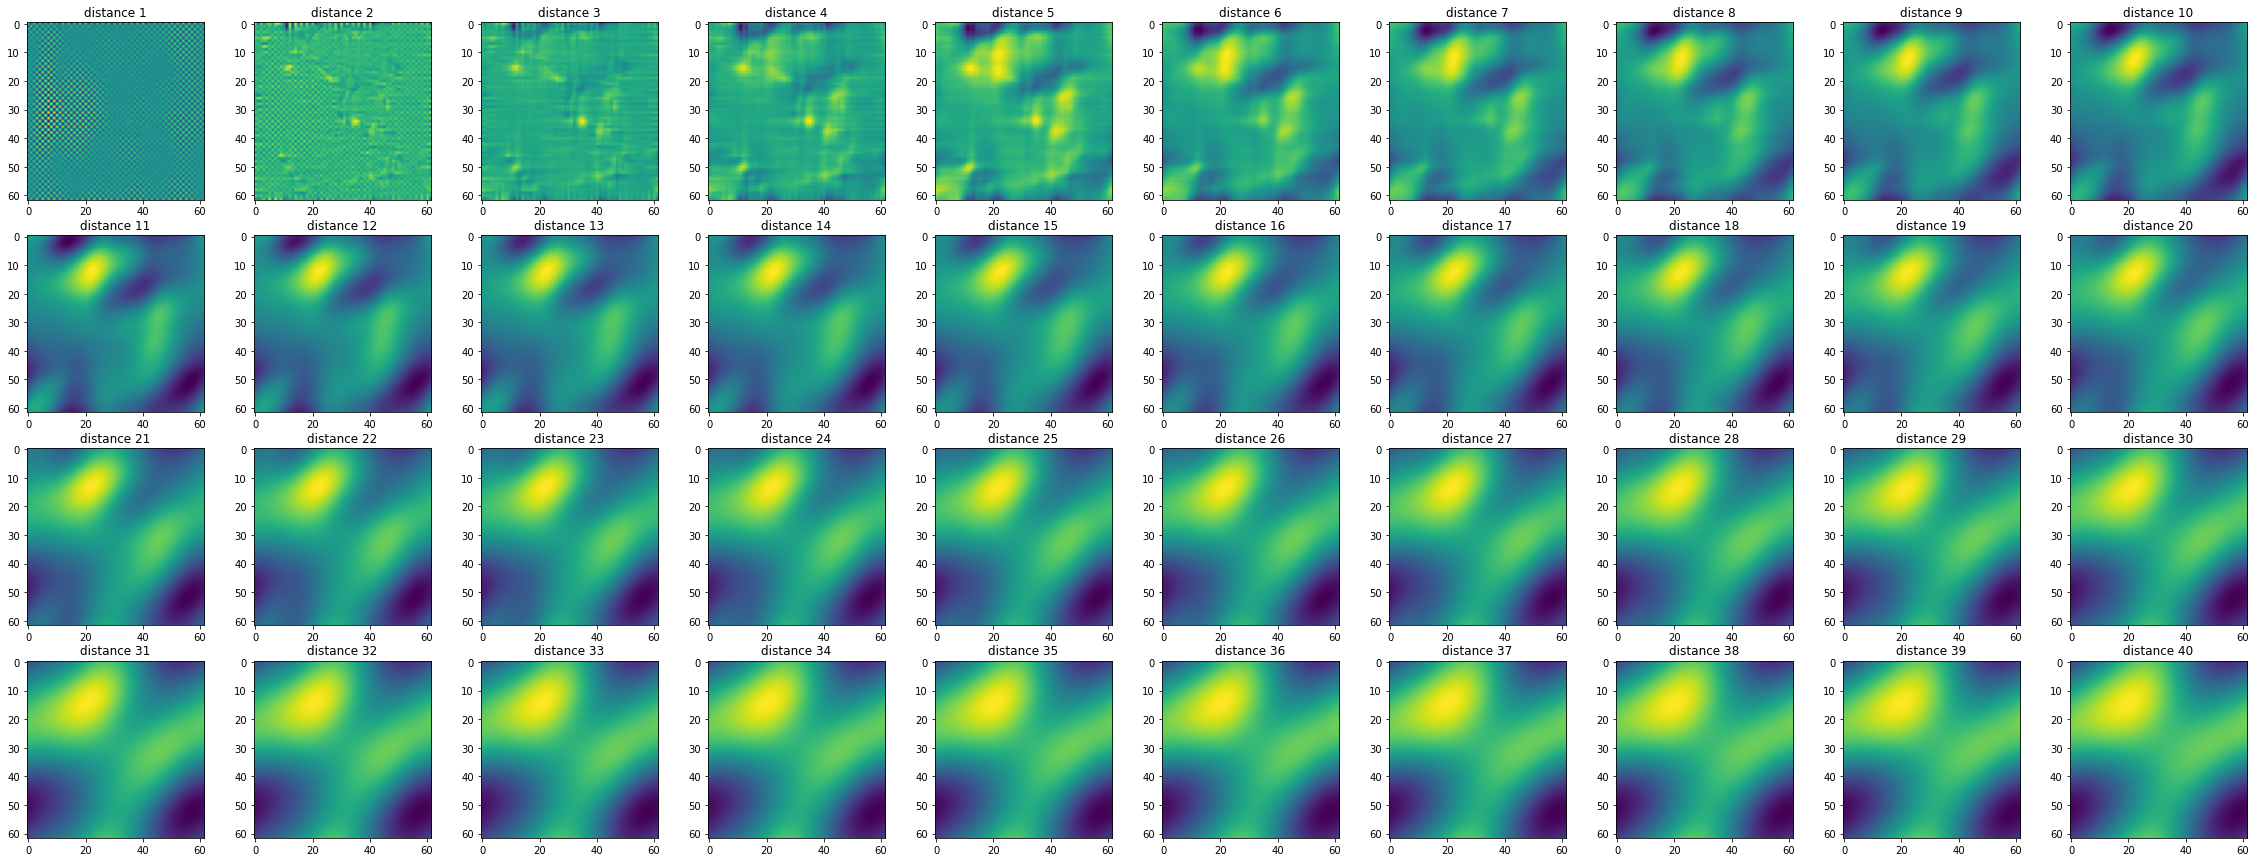

In [19]:
fig = plt.figure(figsize=(40, 15))
columns = 10
rows = 4
for z in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, z)
    plt.imshow(Inv0_real_norm_complete[:,:,z-1])
    plt.title(f'distance {z}')
plt.show()

In [ ]:
import plotly.graph_objects as go

# inversion of axis 
volume = Inv0_real_norm_complete.T
volume = volume[::-1,:,:]

# Define frames
r, c = volume[0].shape
cmin = np.min(volume)
cmax = np.max(volume)

nb_frames = volume.shape[0]

fig = go.Figure(frames=[go.Frame(data=go.Surface(
    z=(6.7 - k * 0.1) * np.ones((r, c)),
    surfacecolor=np.flipud(volume[nb_frames - 1 - k]),
    cmin=cmin, cmax=cmax
    ),
    name=str(k) # you need to name the frame for the animation to behave properly
    )
    for k in range(nb_frames)])

# Add data to be displayed before animation starts
fig.add_trace(go.Surface(
    z=6.7 * np.ones((r, c)),
    surfacecolor=np.flipud(volume[nb_frames - 1]),
    colorscale='viridis',
    cmin=cmin, cmax=cmax,
    colorbar=dict(thickness=20, ticklen=4)
    ))


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Layout
fig.update_layout(
         title='Slices in volumetric data',
         width=600,
         height=600,
         scene=dict(
                    zaxis=dict(range=[-0.1, 6.8], autorange=False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()